# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [1]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pytorch_forecasting
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
from tft_helper import get_best_lr, tft_trainer, tft_predict, run_hyperparameter_optimization, save_exp_results


c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# PARAMS

In [4]:
model_days = 365 #113
# validation_days = 14
# test_days = 15
n_prev_hours = 24*6
group = 'month'
epochs = 25
exp_path = 'TFT_experiments.xlsx'


lr_finder = False
grid_search = False

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


#TFT params
# tft_params =  {'gradient_clip_val': 0.05808054277495504, 'hidden_size': 32, 'dropout': 0.2997107370422699, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.017853144294677083}
# tft_params =  {'gradient_clip_val': 0.01, 'hidden_size': 36, 'dropout': 0.3, 'hidden_continuous_size': 22, 'attention_head_size': 4, 'learning_rate': 0.001}
# tft_params = {'gradient_clip_val': 0.35, 'hidden_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.001}
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01}


hyperparams_grid = {
    "gradient_clip_val_range": (0.01, 1.0),
    "hidden_size_range": (8, 64),
    "hidden_continuous_size_range": (8, 64),
    "attention_head_size_range": (1, 4),
    "learning_rate_range": (0.001, 0.3),
    "dropout_range": (0.1, 0.3),
    "trainer_kwargs": dict(limit_train_batches=60),
    "reduce_on_plateau_patience": 4,
    "use_learning_rate_finder": False
}




# LOAD DATA

In [5]:
# Cargar los datos
file_path =  './datasets/dataset_input_v1.xlsx'
# file_path =  './datasets/dataset_input_v1.xlsx'

df = pd.read_excel(file_path)

df = df.rename(columns={'EUA': 'co2'})
df['fechaHora'] = pd.to_datetime(df['fechaHora'])

df = df.dropna(subset=['precio_spot'])


In [6]:
df

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
0,2019-01-01 01:00:00,66.88,22781.000000,24.18,24.45,3782.166667,29.166667,19101.300,824.100
1,2019-01-01 02:00:00,66.00,21448.500000,24.18,24.45,3740.333333,23.500000,17924.100,1177.200
2,2019-01-01 03:00:00,63.64,20262.166667,24.18,24.45,3711.500000,14.000000,16725.000,1199.100
3,2019-01-01 04:00:00,58.85,19463.500000,24.18,24.45,3530.000000,14.000000,15826.800,898.200
4,2019-01-01 05:00:00,55.47,19164.000000,24.18,24.45,3390.166667,14.000000,15769.300,57.500
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083000,64.54,30.43,11333.333000,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333000,64.54,30.43,13670.417000,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833000,64.54,30.43,13265.333000,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417000,64.54,30.43,12733.917000,932.833333,14830.575,2281.050


<!-- ## DF FINL -->

In [7]:
now = pd.Timestamp.now()
last_day = df['fechaHora'].iloc[-1]
# Calcula la fecha hace dos meses utilizando timedelta
fecha_start = (last_day - pd.Timedelta(days=model_days)).replace(hour=0, minute=0, second=0)

# Filtra las filas 
df_last = df[df['fechaHora'] >= fecha_start]
df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])



C:\Users\nicov\AppData\Local\Temp\ipykernel_4036\866086546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])


In [8]:
df_last

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
37751,2023-04-23 00:00:00,108.00,20607.000,88.76,34.59,8589.917,346.333333,12367.325,2025.075
37752,2023-04-23 01:00:00,97.52,19405.250,88.76,34.59,8951.833,238.666667,10871.725,1495.600
37753,2023-04-23 02:00:00,95.02,18445.833,88.76,34.59,9192.583,236.666667,9538.450,1333.275
37754,2023-04-23 03:00:00,89.44,17952.000,88.76,34.59,9227.917,217.916667,8763.675,774.775
37755,2023-04-23 04:00:00,86.67,17793.000,88.76,34.59,8885.250,211.416667,8246.650,517.025
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083,64.54,30.43,11333.333,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333,64.54,30.43,13670.417,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833,64.54,30.43,13265.333,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417,64.54,30.43,12733.917,932.833333,14830.575,2281.050


## DATA SPLIT

In [9]:

data = df_last.copy()
data = data.reset_index(drop=True)
data = data.drop_duplicates('fechaHora', keep='last')



In [10]:
data = data[data['fechaHora'] < '2024-04-22 00:00:00']


In [11]:


data['month'] = data['fechaHora'].dt.to_period('M').astype(str).astype('category').cat.codes
data['week'] = data['fechaHora'].dt.strftime('%Y-%U').astype(str).astype('category').cat.codes
# data['day'] = data['fechaHora'].dt.day.astype('category').cat.codes

data['day'] = (data['fechaHora'] - data['fechaHora'].min()).dt.days
data['hour'] = data['fechaHora'].dt.hour


data['time_idx'] = data.groupby(group).cumcount() 



In [12]:
data


,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa,month,week,day,hour,time_idx
0,2023-04-23 00:00:00,108.00,20607.000,88.76,34.59,8589.917,346.333333,12367.325,2025.075,0,0,0,0,0
1,2023-04-23 01:00:00,97.52,19405.250,88.76,34.59,8951.833,238.666667,10871.725,1495.600,0,0,0,1,1
2,2023-04-23 02:00:00,95.02,18445.833,88.76,34.59,9192.583,236.666667,9538.450,1333.275,0,0,0,2,2
3,2023-04-23 03:00:00,89.44,17952.000,88.76,34.59,9227.917,217.916667,8763.675,774.775,0,0,0,3,3
4,2023-04-23 04:00:00,86.67,17793.000,88.76,34.59,8885.250,211.416667,8246.650,517.025,0,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2024-04-21 19:00:00,0.44,22374.750,66.94,30.43,9304.167,8661.083333,7424.050,-5850.100,12,53,364,19,499
8757,2024-04-21 20:00:00,3.35,24597.167,66.94,30.43,11693.250,2150.333333,13394.350,-5970.300,12,53,364,20,500
8758,2024-04-21 21:00:00,8.93,26634.917,66.94,30.43,13336.333,542.083333,14766.600,-1372.250,12,53,364,21,501
8759,2024-04-21 22:00:00,7.46,25823.667,66.94,30.43,13501.417,506.583333,12327.600,2439.000,12,53,364,22,502


## TimeSeriesDataset

In [13]:

features = [col for col in data.columns if col != 'precio_spot' ]  # Columnas de características and col != 'fechaHora'

max_prediction_length = 24
max_encoder_length = n_prev_hours #48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="precio_spot",
    group_ids=[group],
   min_encoder_length=24,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    #min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[], # group of categorical variables can be treated as one variable
    time_varying_known_reals=features,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['precio_spot'],
    lags={'precio_spot': [24,48,72]},
    target_normalizer=GroupNormalizer('robust',
        groups=[group],
        transformation="softplus"
    ),
  
   # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    # allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        'month':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'week':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'day':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        
    },
)

validation = TimeSeriesDataSet.from_dataset(train, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=11, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)


c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [14]:
validation

TimeSeriesDataSet[length=13](
	time_idx='time_idx',
	target='precio_spot',
	group_ids=['month'],
	weight=None,
	max_encoder_length=144,
	min_encoder_length=24,
	min_prediction_idx=0,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=[],
	static_reals=['encoder_length', 'precio_spot_center', 'precio_spot_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['fechaHora', 'demanda', 'co2', 'precio_gas', 'prod_eolica', 'prod_solar', 'demanda_residual', 'rampa', 'month', 'week', 'day', 'hour', 'time_idx', 'relative_time_idx', 'precio_spot_lagged_by_24', 'precio_spot_lagged_by_48', 'precio_spot_lagged_by_72'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['precio_spot'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={'precio_spot': [24, 48, 72]},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='robust',
	groups=


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [15]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

## TRAIN MODEL

In [17]:
if not grid_search:
    # tft_params['learning_rate'] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, model_path='model_month_365_360', **tft_params)
    save_exp_results(exp_path, tft_params, model_days, n_prev_hours, group, val_loss, epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics             

Epoch 24: 100%|██████████| 64/64 [00:57<00:00,  1.12it/s, v_num=73, train_loss_step=2.780, val_loss=3.780, train_loss_epoch=2.820]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:57<00:00,  1.11it/s, v_num=73, train_loss_step=2.780, val_loss=3.780, train_loss_epoch=2.820]
Number of parameters in network: 142.3k


c:\Users\nicov\Documents\Github\SPOT-Price-Forecast-NN\src\tft_helper.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tft_exps = tft_exps.append(new_exp, ignore_index=True)


### EVAL MODEL

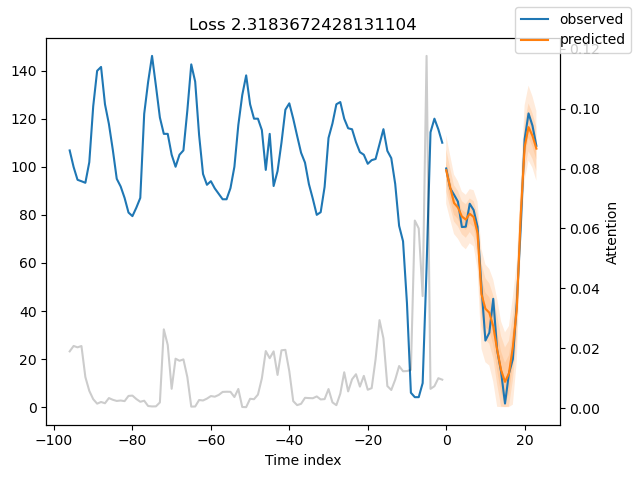

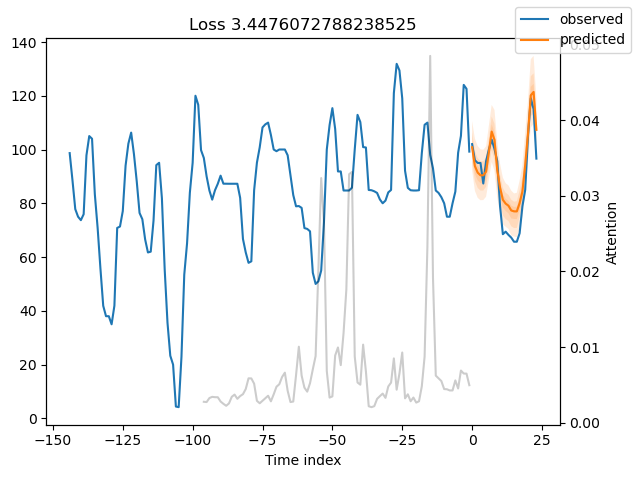

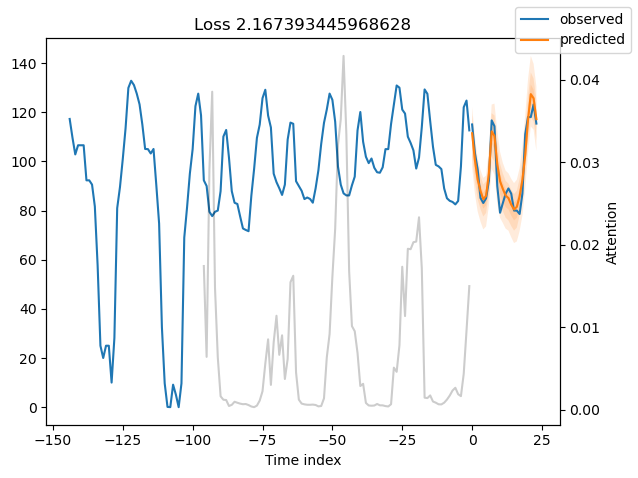

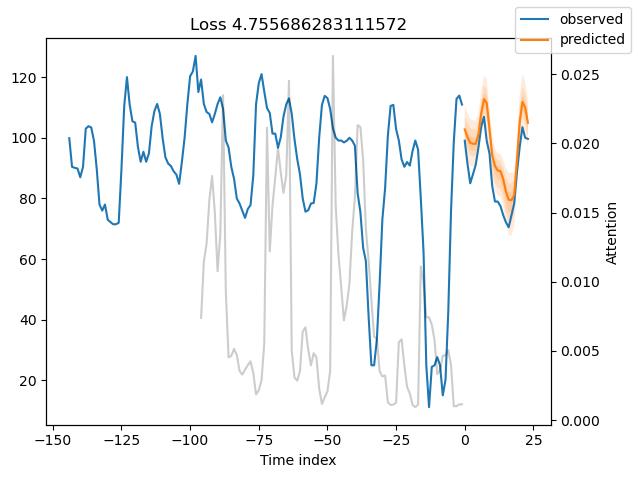

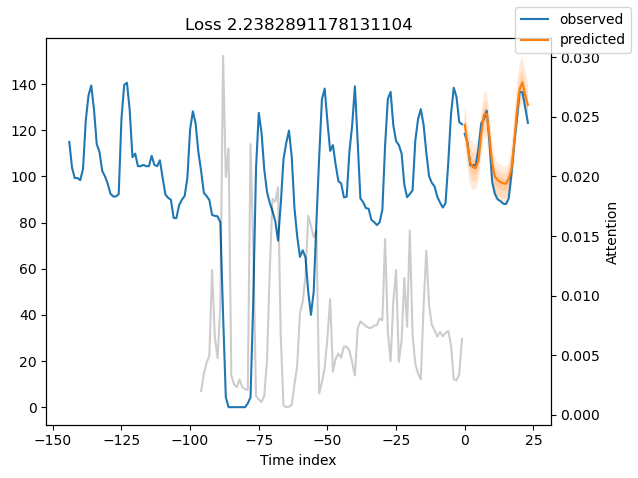

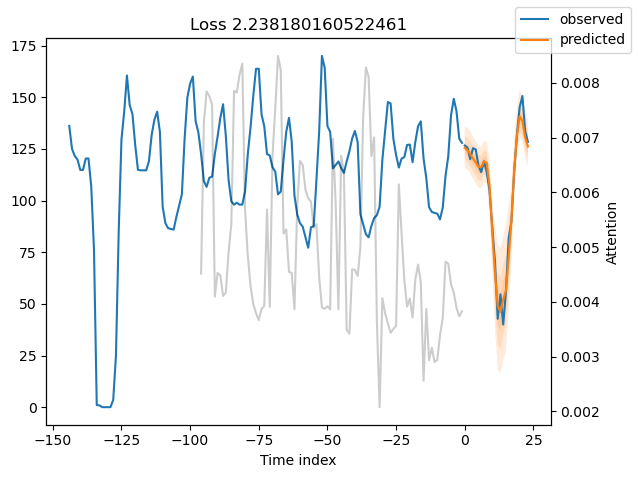

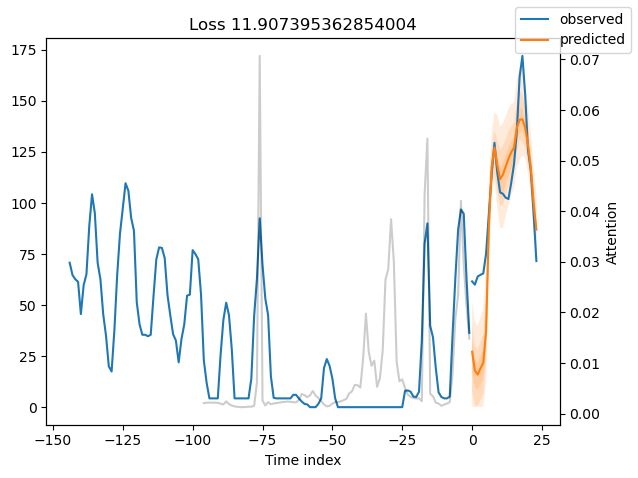

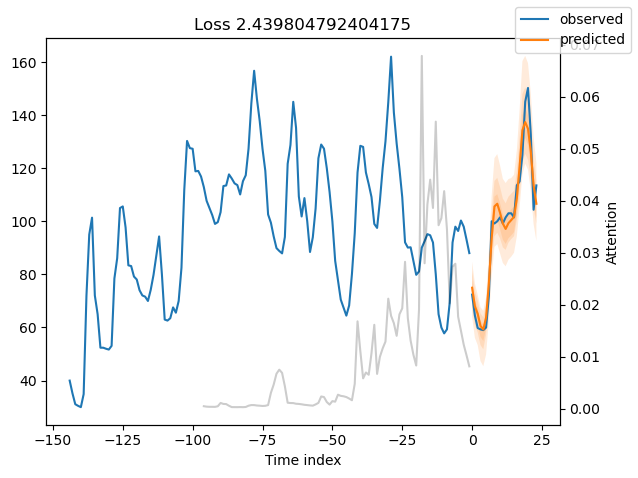

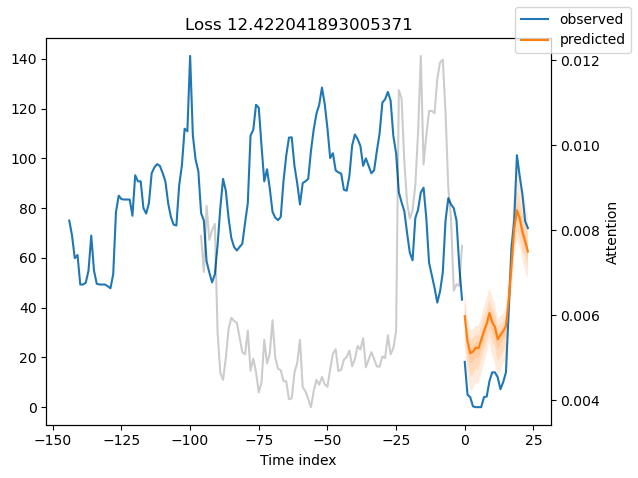

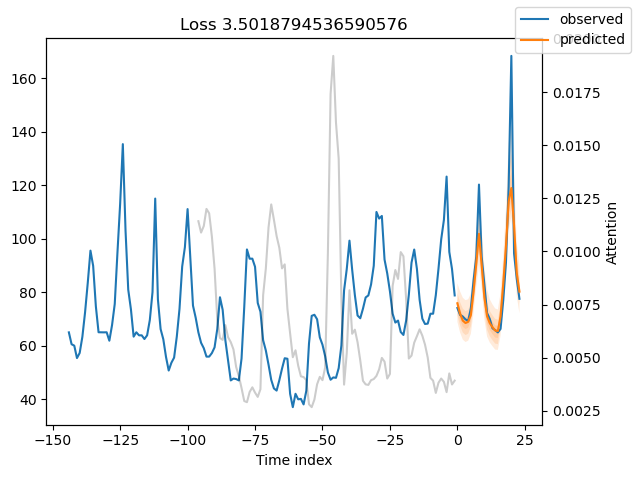

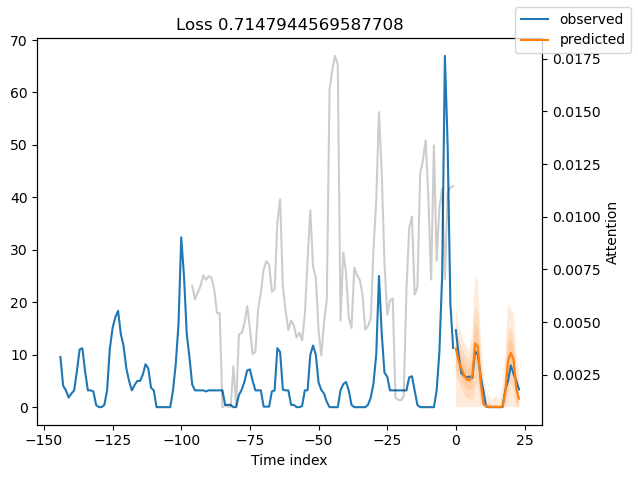

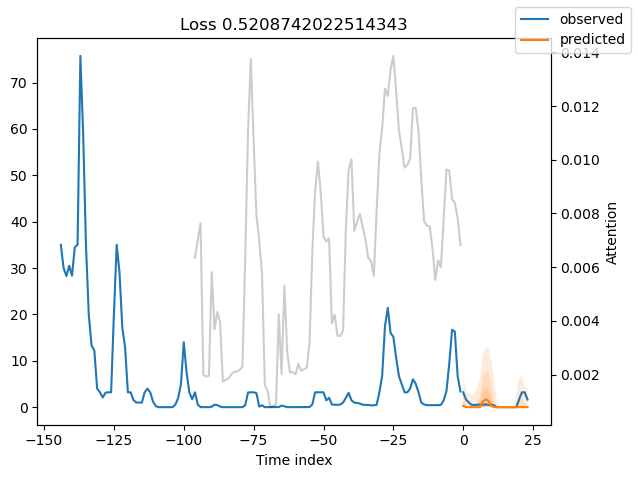

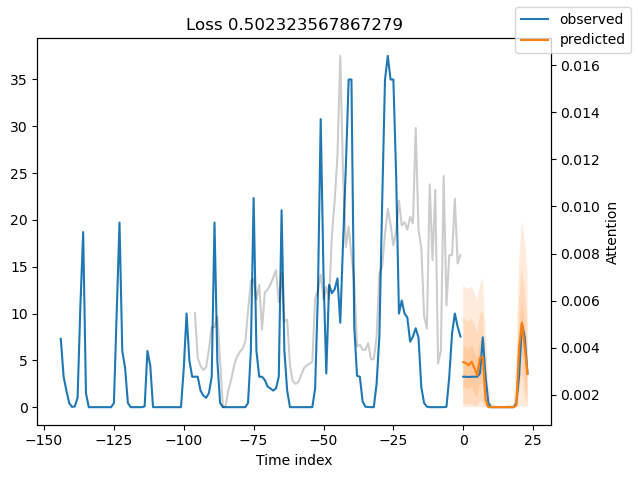

In [18]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


## GRID SEARCH

In [ ]:
if grid_search:
    study, best_tft = run_hyperparameter_optimization(train, train_dataloader, val_dataloader, n_trials=50, max_epochs=30, **hyperparams_grid)
    print(study.best_trial.params)

### EVAL BEST FOUND MODEL

In [ ]:
if grid_search:
    tft_predict(best_tft, val_dataloader, n_preds=10)


# INTERPRETABILITY

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x650 with 1 Axes>,
 'decoder_variables': <Figure size 700x625 with 1 Axes>}

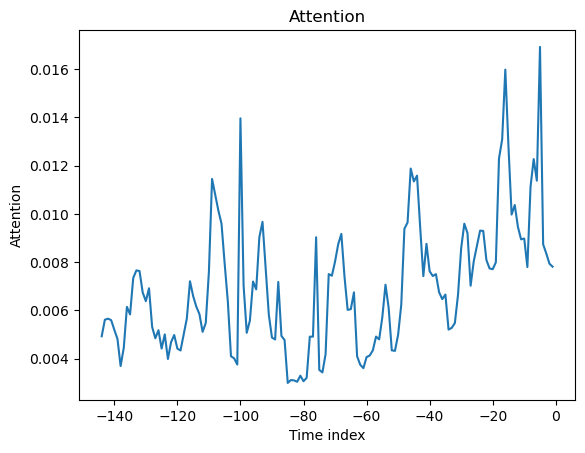

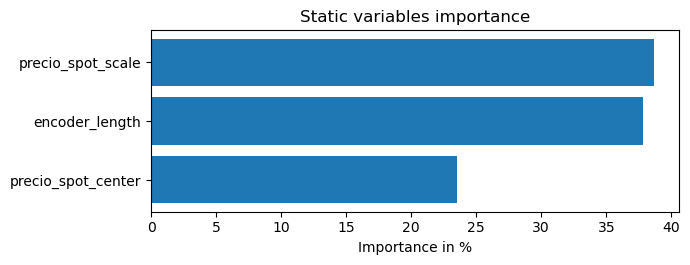

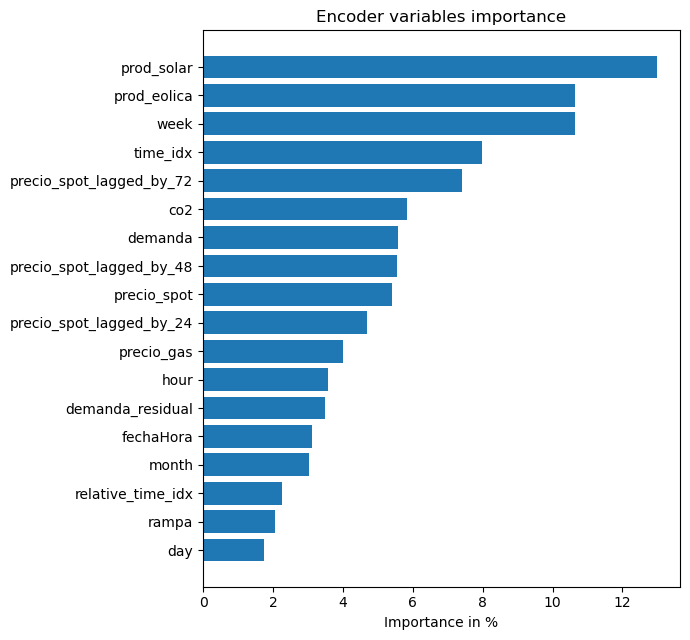

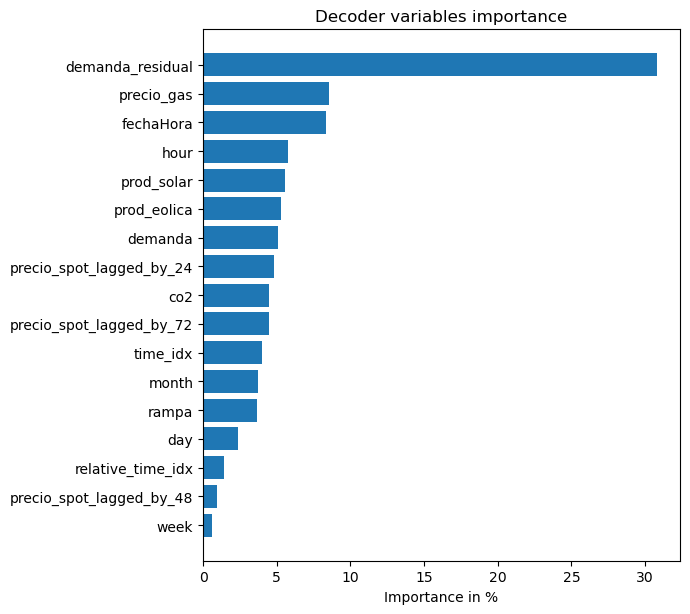

In [27]:
interpretation = tft.interpret_output(preds.output, reduction="sum") #
tft.plot_interpretation(interpretation)
